# Compare analyzers on ImageNet

In this notebook we show how one can use **iNNvestigate** to analyze the prediction of ImageNet-models! To do so we will load a network from the keras.applications module and analyze prediction on some images!

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

-----

**To use this notebook please download the example images using the following script:**

`innvestigate/examples/images/wget_imagenet_2011_samples.sh`

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


## Model

In this demo use the VGG16-model, which uses ReLU activation layers.

In [3]:
# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, os.environ.get("NETWORKNAME", "vgg16"))
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

## Data

Now we load some example images and preprocess them to fit the input size model.

To analyze your own example images, just add them to `innvestigate/examples/images`.

In [4]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`.

Note: Should you run into resource trouble, e.g. you are running that notebook on a computer without GPU or with only limited GPU memory, consider deactivating one or more analyzers by commenting the corresponding lines in the next cell.

In [5]:
patterns = net["patterns"]
input_range = net["input_range"]
nscale = (input_range[1]-input_range[0]) * 0.1

# Methods we use and some properties.
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Show input.
    ("input",                 {},                       imgnetutils.image,         "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
    ("smoothgrad",            {"augment_by_n": 64,
                               "noise_scale": nscale,
                               "postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),
    ("integrated_gradients",  {"steps": 64,
                               "postprocess": "abs"},   imgnetutils.graymap,       "Integrated Gradients"),

    # Signal
    ("deconvnet",             {},                       imgnetutils.bk_proj,       "Deconvnet"),
    ("guided_backprop",       {},                       imgnetutils.bk_proj,       "Guided Backprop",),
    ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

    # Interaction
    ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"),
    ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"),
    ("lrp.z",                 {},                       imgnetutils.heatmap,       "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           imgnetutils.heatmap,       "LRP-Epsilon"),
    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat"),
    ("lrp.sequential_preset_b_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetBFlat"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above and compute the analyses.

In [6]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                model_wo_softmax, # model without softmax output
                                                **method[1])      # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

Now we analyze each image with the different analyzers:

In [7]:
analysis = np.zeros([len(images), len(analyzers)]+net["image_shape"]+[3])
text = []

for i, (x, y) in enumerate(images):
    # Add batch axis.
    x = x[None, :, :, :]
    x_pp = imgnetutils.preprocess(x, net)

    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x_pp)[0]
    prob = model.predict_on_batch(x_pp)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = x/255
        elif analyzer:
            # Analyze.
            a = analyzer.analyze(x_pp)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = imgnetutils.postprocess(a, color_conversion, channels_first)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        # Store the analysis.
        analysis[i, aidx] = a[0]

Next, we visualize the analysis results:

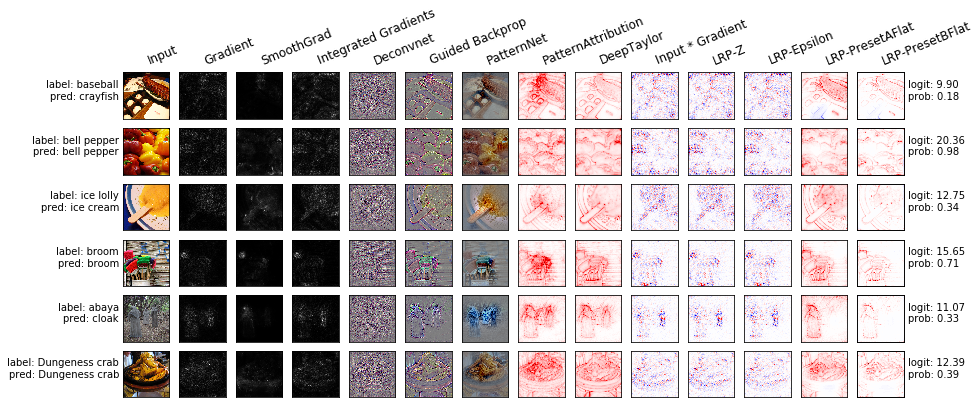

In [8]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]),'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("plot_file_name", None))

This figure shows the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).


If you are curious about how **iNNvestigate** performs on *different* ImageNet model, have a look here: [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)